In [126]:
import matplotlib
import pylab as plt
import astropy
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import speclite.filters

In [127]:
# Exposure time predictions for CFHT POLU medium-band survey

In [128]:
# Assumed survey area in sq deg
survey_area = 1000

In [212]:
# Medium-band filters -- we're going to assume constant-throughput, top-hat filters.
# This is the constant throughput
mb_eff = 0.92

#               name   Llow   Lhigh  Lsource
mb_filters = [('CaHK', 3905., 4005., 3955.0),
              #('MB0',  3750., 4006., 3878.0),
              ('MB1',  4005., 4265., 4135.0),]

In [213]:
# These are the line fluxes we assume, in units of 1e-16 erg/s/cm^2.

mb_line_fluxes = [1.0, 1.0]

# Anand - DESI-2 1000/sq deg.
# desi-2
#mb_line_fluxes = [1.8, 1.92, 1.66]
'''
# FILT ZMIN ZMAX FLIM NLAE_PER_MPC3 NLAE_PER_DEG2
MB0    2.08    2.30    1.92e-16    1.2e-03    139
MB1    2.30    2.51    1.66e-16    1.2e-03    141
MB2    2.51    2.72    1.43e-16    1.2e-03    144
MB3    2.72    2.93    1.28e-16    1.2e-03    139
MB4    2.93    3.14    1.12e-16    1.2e-03    136
MB5    3.14    3.36    9.60e-17    1.2e-03    137
N540    3.36    3.53    7.70e-17    1.2e-03    131
''';

In [214]:
# Hours per night assumed in the final reporting
hrs_per_night = 5.0

In [215]:
# Seeing and effective telescope diameters

seeings = {
    'CFHT': 0.8,
    'DECam': 1.2,
}

tel_diams = {
    'CFHT': 3.5 * u.m,
    'DECam': 3.51 * u.m, # DECam ETC spreadsheet, 9.70 sq m
}

In [216]:
pixscales = {
    'CFHT'   : 0.185,
    'DECam'  : 0.262,
}

# Number of pixels in the camera
cam_pix = {
    'CFHT':    40 * 2048 * 4612,
    'DECam':   60 * 2048 * 4096,
}

# Effective area per exposure, in square degrees
cam_sqdeg = {}
for k,v in cam_pix.items():
    cam_sqdeg[k] = v * (pixscales[k]/3600.)**2
cam_sqdeg

{'CFHT': 0.9977407209876543, 'DECam': 2.6658685534814817}

In [217]:
# Assumed galaxy size (Gaussian sigma), in arcsec
gal_size = 0.15 # arcsec

# Target S/N of source detection
#snr = 6.
snr = 5.

In [218]:
# Another "magic number" is the correction we apply to the LSST model sky spectrum.
# Search for "sky_scale" below.

In [219]:
# Now define a few functions for reading data files...

In [220]:
def read_lsst_throughput(fn, basedir='lsst-throughputs-1.9', wave_factor = 10.,
                        assert_2_words=True):
    fullfn = os.path.join(basedir, fn)
    vals = []
    for line in open(fullfn).readlines():
        line = line.strip()
        if line.startswith('#'):
            continue
        words = line.split()
        if len(words) == 0:
            continue
        if assert_2_words:
            assert(len(words) == 2)
        vals.append((float(words[0]), float(words[1])))
    vals = np.array(vals)
    # Bizarro subaru m1 file is not sorted!!
    I = np.argsort(vals[:,0])
    vals = vals[I,:]
    # Wavelength (nm->A), throughput
    return vals[:,0] * wave_factor, vals[:,1]

In [221]:
def read_uves_spectrum(fn):
    hdu = fits.open(fn)[0]
    hdr = hdu.header
    sky_flux = hdu.data
    crpix, crval, cdelt = hdr['CRPIX1'], hdr['CRVAL1'], hdr['CDELT1']
    sky_pix = (1 + np.arange(len(sky_flux)))
    sky_wave = crval + (sky_pix - crpix) * cdelt
    return sky_wave, sky_flux

In [222]:
# Read CFHT data tables...
def read_table(fn, wavelengths, sep=None, wave_scale=10., trans_scale=0.01):
    f = open(fn)
    qe = []
    for line in f.readlines():
        words = line.strip().split(sep=sep)
        #if len(words) != 2:
        #    continue
        try:
            f1,f2 = float(words[0]), float(words[1])
        except:
            continue
        qe.append([wave_scale * f1, trans_scale * f2])
    qe = np.array(qe)
    if wavelengths is None:
        return qe
    qe_wave = qe[:,0] * u.Angstrom
    qe_frac = qe[:,1]
    qe = np.interp(wavelengths, qe_wave, qe_frac)
    return qe

In [223]:
# First up, read the dark sky model.  We have three available:
# - UVES - from https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html
#               https://ui.adsabs.harvard.edu/abs/2003A%26A...407.1157H/abstract
# - DESI - used for DESI sims
#          https://desi.lbl.gov/trac/browser/code/desimodel/trunk/data/spectra/spec-sky.dat
# - LSST - estimated for predictions; version 1.9 of
#          https://github.com/lsst/throughputs/blob/1.9/baseline/darksky.dat

In [224]:
# the UVES spectra are split into pieces... join them together
wave1,flux1 = read_uves_spectrum('fluxed_sky_346.fits')
wave2,flux2 = read_uves_spectrum('fluxed_sky_437.fits')
wave3,flux3 = read_uves_spectrum('fluxed_sky_580L.fits')
split12 = 3760.
split23 = 4850.
I1 = (wave1 < split12)
I2 = (wave2 >= split12) * (wave2 < split23)
I3 = (wave3 >= split23)
sky_wave = np.hstack((wave1[I1], wave2[I2], wave3[I3]))
sky_flux = np.hstack((flux1[I1], flux2[I2], flux3[I3]))
# The UVES sky fluxes are in 1e-16 erg/(s A cm^2 arcsec^2)
uves_sky_wave = sky_wave * u.Angstrom
# per arcsec^2
uves_sky_flux = sky_flux * 1e-16 * u.erg / (u.cm**2 * u.s * u.Angstrom)

In [225]:
# Next, a spectrum used for DESI sims.
#desi_sky = read_table('spec-sky.dat', sky_wave_u, wave_scale=1., trans_scale=1.)
desi_sky = read_table('spec-sky-cut.dat', None, wave_scale=1., trans_scale=1.)
desi_sky_wave = desi_sky[:,0] * u.Angstrom
desi_sky_flux = desi_sky[:,1] * 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom)

In [226]:
# Finally, the dark sky model from the LSST throughputs repo
w,f = read_lsst_throughput('darksky.dat')
# is in "Flambda(ergs/cm^s/s/nm)"
f *= 0.1 # -> to ergs/cm^2/s/A
lsst_sky_wave = w * u.Angstrom
lsst_sky_flux = f * u.erg / (u.cm**2 * u.s * u.Angstrom)
#lsst_sky = interp1d(w,f)
#lsst_sky = interp1d(wavegrid, lsst_sky, bounds_error=False, fill_value=0.)
#lsst_sky_u = lsst_sky(sky_wave_u) * sky_flux_u.unit

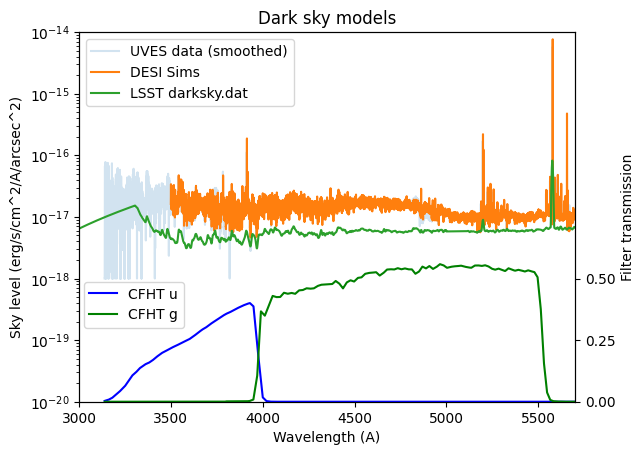

In [227]:
filters = speclite.filters.load_filters('cfht_megacam-u', 'cfht_megacam-g')

uves2 = gaussian_filter(uves_sky_flux, 5.)
plt.semilogy(uves_sky_wave, np.maximum(1e-18, uves2),  label='UVES data (smoothed)', alpha=0.2);
#plt.semilogy(uves_sky_wave, np.maximum(1e-18, uves_sky_flux.value),  label='UVES data', alpha=0.2);
plt.semilogy(desi_sky_wave, desi_sky_flux, label='DESI Sims');
plt.semilogy(lsst_sky_wave, lsst_sky_flux, label='LSST darksky.dat');
plt.legend()
plt.ylim(1e-20, 1e-14);
plt.xlabel('Wavelength (A)')
plt.ylabel('Sky level (erg/s/cm^2/A/arcsec^2)')
plt.xlim(3000, 5700)

# Also plot the u,g filters
plt.twinx()
plt.plot(uves_sky_wave, filters[0].interpolator(uves_sky_wave), 'b', label='CFHT u')
plt.plot(uves_sky_wave, filters[1].interpolator(uves_sky_wave), 'g', label='CFHT g')
plt.ylim(0,1.5)
plt.ylabel('Filter transmission')
plt.yticks([0., 0.25, 0.5])
plt.legend(loc=(0.01, 0.2))#'lower left')

plt.title('Dark sky models')
plt.savefig('sky.png')

In [228]:
# ... from which we can see that the LSST model is considerably more optimistic...

In [229]:
filters = speclite.filters.load_filters('decam2014-u', 'decam2014-g', 'bessell-U', 'bessell-B', 'cfht_megacam-u', 'cfht_megacam-g')

print('UVES sky model:')
for f in filters:
    sky_flux,sky_wave = f.pad_spectrum(uves_sky_flux, uves_sky_wave, method='zero')
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(sky_flux, sky_wave))

print()
print('DESI sky model:  --  NOTE that the cfht-u and bessell-U are wrong because the spectrum is truncated')
for f in filters:
    sky_flux,sky_wave = f.pad_spectrum(desi_sky_flux, desi_sky_wave, method='zero')
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(sky_flux, sky_wave))

print()
print('LSST sky model:')
for f in filters:
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(lsst_sky_flux, lsst_sky_wave))    

UVES sky model:
Filter     decam2014-u : sky is 21.82 mag / arcsec^2
Filter     decam2014-g : sky is 21.40 mag / arcsec^2
Filter       bessell-U : sky is 21.79 mag / arcsec^2
Filter       bessell-B : sky is 21.46 mag / arcsec^2
Filter  cfht_megacam-u : sky is 21.78 mag / arcsec^2
Filter  cfht_megacam-g : sky is 21.40 mag / arcsec^2

DESI sky model:  --  NOTE that the cfht-u and bessell-U are wrong because the spectrum is truncated
Filter     decam2014-u : sky is 21.85 mag / arcsec^2
Filter     decam2014-g : sky is 21.39 mag / arcsec^2
Filter       bessell-U : sky is 22.21 mag / arcsec^2
Filter       bessell-B : sky is 21.46 mag / arcsec^2
Filter  cfht_megacam-u : sky is 22.08 mag / arcsec^2
Filter  cfht_megacam-g : sky is 21.40 mag / arcsec^2

LSST sky model:
Filter     decam2014-u : sky is 22.85 mag / arcsec^2
Filter     decam2014-g : sky is 22.23 mag / arcsec^2
Filter       bessell-U : sky is 22.90 mag / arcsec^2
Filter       bessell-B : sky is 22.49 mag / arcsec^2
Filter  cfht_megac

In [230]:
# Which one should we use?
# This paper
#   https://ui.adsabs.harvard.edu/abs/2007PASP..119..687K/abstract
# gives CTIO average measurements of U ~ 22.12 and B ~ 22.82 (Table 6)

# The Dark Energy Survey DR1
#   https://ui.adsabs.harvard.edu/abs/2018ApJS..239...18A/abstract
# reports a median g ~ 22.01

# This web page
#   https://www.cfht.hawaii.edu/Instruments/Imaging/Megacam/quickinformation.html
# reports CFHT Megacam u ~ 22.70, g ~ 22.00 at zenith, 0% moon

In [231]:
# I am therefore going to take the LSST sky model but scale it to be 0.26 mag brighter!
sky_scaling = 10.**((-0.26) / -2.5)
sky_scaling

I = np.flatnonzero(lsst_sky_wave.value < 6000)
sky_wave = lsst_sky_wave[I]
sky_flux = lsst_sky_flux[I] * sky_scaling

print('Brightened LSST sky model:')
for f in filters:
    if 'bessell' in f.name:
        continue
    pf,pw = f.pad_spectrum(sky_flux, sky_wave, method='zero')   
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(pf, pw))

Brightened LSST sky model:
Filter     decam2014-u : sky is 22.79 mag / arcsec^2
Filter     decam2014-g : sky is 22.00 mag / arcsec^2
Filter  cfht_megacam-u : sky is 22.71 mag / arcsec^2
Filter  cfht_megacam-g : sky is 22.02 mag / arcsec^2


In [232]:
# Next up, we try to figure out transmission curves for each telescope under consideration.
# In general, we're doing this by referring to information produced by each observatory.
# For comparison, we have 'speclite' filter curves for some combinations.

In [233]:
wavegrid = sky_wave

In [234]:
# Define Medium-band filters
MB = []
for F in mb_filters:
    lo,hi = F[1], F[2]
    f = interp1d(wavegrid, mb_eff * (wavegrid.value >= lo) * (wavegrid.value < hi), bounds_error=False, fill_value=0.)
    f.name = F[0]
    MB.append(f)

In [235]:
# CFHT:
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/QE_camera.dat
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/Optics_TR.dat
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/Al_coating.dat
# https://www.cfht.hawaii.edu/Instruments/Filters/curves/cfh9302.dat
# from https://www.cfht.hawaii.edu/Instruments/Filters/megaprime.html

# CCD QE
qe = read_table('cfht/QE_camera.dat', sky_wave)
# Optics_TR.dat
optics = read_table('cfht/Optics_TR.dat', sky_wave)
# Mirror - Al_coating.dat
mirror = read_table('cfht/Al_coating.dat', sky_wave)

cfht_thru = interp1d(sky_wave, qe * optics * mirror)

# Filters - 
cfht_u_filt    = interp1d(sky_wave, read_table('cfht/cfh9302.dat', sky_wave, sep=','))
cfht_g_filt    = interp1d(sky_wave, read_table('cfht/cfh9402.dat', sky_wave, sep=','))
cfht_cahk_filt = interp1d(sky_wave, read_table('cfht/cfh9303.dat', sky_wave, sep=','))

In [236]:
# For DECam, we did not try to find the individual transmission curves, and will instead scale the 'speclite'
# filter curves, below

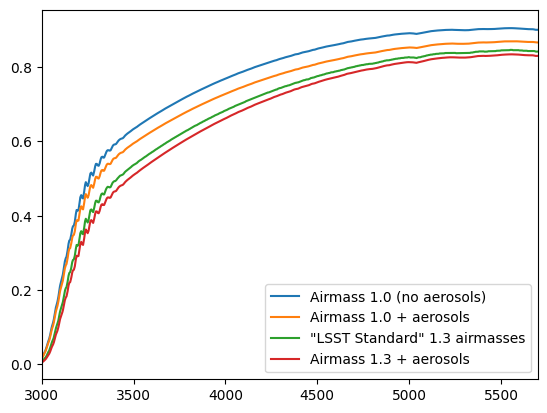

In [237]:
# Another big choice we have is the atmosphere model.  The LSST sims have a variety of models,
# at different airmasses, and with/without aerosols.  These make quite a big difference!
atm = interp1d(*read_lsst_throughput('atmos_std.dat'))
atm10 = interp1d(*read_lsst_throughput('atmos_10.dat'))
atm10_noaero = interp1d(*read_lsst_throughput('atmos_10.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
#atm12_hi = interp1d(*read_lsst_throughput('atmos_12_hiwater.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
#atm12_lo = interp1d(*read_lsst_throughput('atmos_12_lowater.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
# Water doesn't make a difference for us in the blue -- but aerosols do!
#atm12_hi_a = interp1d(*read_lsst_throughput('atmos_12_hiwater_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
#atm12_lo_a = interp1d(*read_lsst_throughput('atmos_12_lowater_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
atm13_a = interp1d(*read_lsst_throughput('atmos_13_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
wave = sky_wave
plt.plot(wave, atm10_noaero(wave), label='Airmass 1.0 (no aerosols)')
plt.plot(wave, atm10(wave), label='Airmass 1.0 + aerosols')
plt.plot(wave, atm(wave), label='"LSST Standard" 1.3 airmasses')
plt.plot(wave, atm13_a(wave), label='Airmass 1.3 + aerosols')
plt.xlim(3000, 5700)
plt.legend();

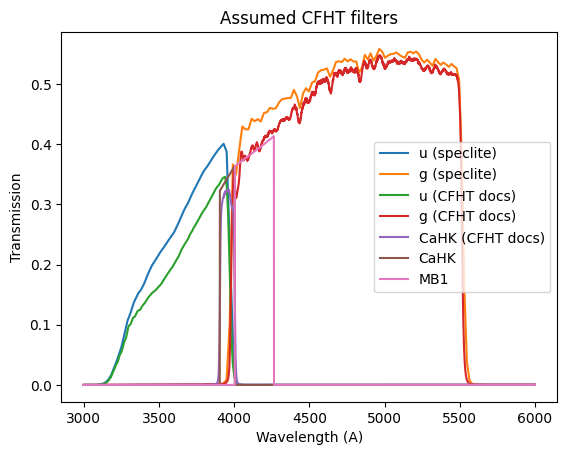

In [238]:
cfht_filters = speclite.filters.load_filters('cfht_megacam-u', 'cfht_megacam-g')

cfht_atm = atm

atmo = cfht_atm(sky_wave)
thru = cfht_thru(sky_wave)
#speclite.filters.plot_filters(cfht_filters)
plt.plot(sky_wave, cfht_filters[0].interpolator(sky_wave), label='u (speclite)');
plt.plot(sky_wave, cfht_filters[1].interpolator(sky_wave), label='g (speclite)');
plt.plot(sky_wave, thru * cfht_u_filt(sky_wave) * atmo, label='u (CFHT docs)');
plt.plot(sky_wave, thru * cfht_g_filt(sky_wave) * atmo, label='g (CFHT docs)');
plt.plot(sky_wave, thru * cfht_cahk_filt(sky_wave) * atmo, label='CaHK (CFHT docs)');

for mb in MB:
    plt.plot(sky_wave, thru * mb(sky_wave) * atmo, label=mb.name)

plt.xlabel('Wavelength (A)')
plt.ylabel('Transmission')
plt.title('Assumed CFHT filters')
plt.legend();

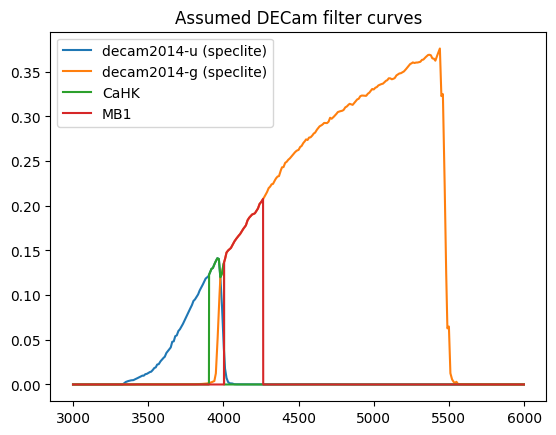

In [239]:
decam_filters = speclite.filters.load_filters('decam2014-u', 'decam2014-g')
for f in decam_filters:
    plt.plot(sky_wave, f.interpolator(sky_wave), label=f.name + ' (speclite)')

decam_u = decam_filters[0].interpolator
decam_g = decam_filters[1].interpolator
decam_thru = np.maximum(decam_u(sky_wave), decam_g(sky_wave))
# The g-band transmission drops off before the r-band picks up -- assume the throughput would actually
# be flat at the max g value.  This avoids suppressing the red end of MB6.
#i = np.argmax(decam_thru)
#decam_thru[i:] = decam_thru[i]
# Correct for the assumed 95% MB throughput
decam_thru /= mb_eff
decam_thru = interp1d(sky_wave.value, decam_thru)

# This decam_thru already has atmospheric extinction, so set to 1.0
decam_atm = lambda x: np.ones(len(x))

for i,mb in enumerate(MB):
    #if i < 1:
    #    continue
    plt.plot(wavegrid, decam_thru(wavegrid) * decam_atm(wavegrid) * mb(wavegrid),
            label=mb.name)
plt.title('Assumed DECam filter curves')
plt.legend(loc='upper left');

In [240]:
mbnames = dict([(i,mb.name) for i,mb in enumerate(MB)])

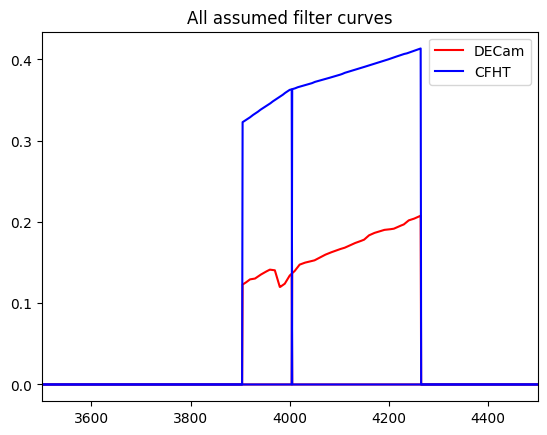

In [241]:
combos = []

def thrufunc(w,tel,atm,mb):
    f = interp1d(wavegrid, tel(wavegrid)*atm(wavegrid)*mb(wavegrid), bounds_error=False, fill_value=0.)
    return f

for i,mb in enumerate(MB):
    kwa = {}
    if i == 0:
        kwa.update(label='DECam')
    plt.plot(wavegrid, decam_thru(wavegrid) * decam_atm(wavegrid) * mb(wavegrid),
             color='r', **kwa)
    combos.append(('DECam', i, thrufunc(wavegrid, decam_thru, decam_atm, mb)))

for i,mb in enumerate(MB):
    kwa = {}
    if i == 0:
        kwa.update(label='CFHT')
    plt.plot(wavegrid, cfht_thru(wavegrid) * cfht_atm(wavegrid) * mb(wavegrid),
             color='b', **kwa)
    combos.append(('CFHT', i, thrufunc(wavegrid, cfht_thru, cfht_atm, mb)))

NF = len(MB)
combos.append(('CFHT', NF, thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_u_filt)))
combos.append(('CFHT', NF+1, thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_cahk_filt)))
mbnames[NF] = 'u(2)'
mbnames[NF+1] = 'CaHK(2)'

plt.legend();
plt.xlim(3500, 4500);
plt.title('All assumed filter curves')
plt.savefig('thru.png')

In [242]:
# Define AB reference source flux
ref_mag = 20.
ref = speclite.filters.ab_reference_flux(sky_wave, magnitude=ref_mag)

In [243]:
tel_areas = {}
for k,diam in tel_diams.items():
    tel_areas[k] = (np.pi * (diam / 2.)**2).to('cm^2')
tel_areas

{'CFHT': <Quantity 96211.27501619 cm2>, 'DECam': <Quantity 96761.83912873 cm2>}

In [244]:
# Energy of a photon of wavelength sky_wave_u
wave_ergs = (const.h.cgs * const.c.cgs / sky_wave).to('erg')
dwave = np.diff(sky_wave)
dwave = np.append(dwave, [dwave[-1]])

tel_area = tel_areas['CFHT']
ref_photon_rate = ref * dwave * tel_area / wave_ergs
sky_photon_rate = sky_flux * dwave * tel_area / wave_ergs

for tel,mbi,thru in combos:
    if tel != 'CFHT':
        continue
    sky_photons = np.sum(sky_photon_rate * thru(sky_wave))
    sky_photons_perpix = sky_photons * pixscales[tel]**2
    print('%10s %8s: sky count rate is %.2f photons/pixel/sec' % (tel, mbnames[mbi], sky_photons_perpix.value))
print()
print()

sky_mags = {}

for tel,mbi,thru in combos:
    ref_photons = np.sum(ref_photon_rate * thru(sky_wave))
    sky_photons = np.sum(sky_photon_rate * thru(sky_wave))
    sky_mag = ref_mag -2.5 * np.log10(sky_photons / ref_photons)
    sky_mags[(tel,mbi)] = sky_mag
    print('%10s %8s: sky brightness is %.2f mag/arcsec^2' % (tel, mbnames[mbi], sky_mag))

      CFHT     CaHK: sky count rate is 0.13 photons/pixel/sec
      CFHT      MB1: sky count rate is 0.50 photons/pixel/sec
      CFHT     u(2): sky count rate is 0.64 photons/pixel/sec
      CFHT  CaHK(2): sky count rate is 0.13 photons/pixel/sec


     DECam     CaHK: sky brightness is 22.67 mag/arcsec^2
     DECam      MB1: sky brightness is 22.36 mag/arcsec^2
      CFHT     CaHK: sky brightness is 22.67 mag/arcsec^2
      CFHT      MB1: sky brightness is 22.36 mag/arcsec^2
      CFHT     u(2): sky brightness is 22.71 mag/arcsec^2
      CFHT  CaHK(2): sky brightness is 22.64 mag/arcsec^2


In [245]:
# Define line sources in the middle of each filter
srcs = []

for imb,(name,lo,hi,mid) in enumerate(mb_filters):
    src = np.zeros(len(sky_wave))
    i = np.argmin(np.abs(sky_wave - mid*u.Angstrom))
    src[i] = (1e-16 / dwave[i].value)
    src = src * sky_flux.unit
    srcs.append(src)
    print('Filter %8s:' % mbnames[imb], src[i]*dwave[i], 'at %.1f Ang' % mid)

# u(2) and CaHK(2) = [0]
srcs.append(srcs[0])
srcs.append(srcs[0])
mb_line_fluxes.append(mb_line_fluxes[0])
mb_line_fluxes.append(mb_line_fluxes[0])

Filter     CaHK: 1e-16 erg / (s cm2) at 3955.0 Ang
Filter      MB1: 1e-16 erg / (s cm2) at 4135.0 Ang


In [246]:
print('For a line source of 1e-16 erg/sec/cm^2 centered in the filter...')
print()
for tel,mbi,thru in combos:
    src_photon_rate = srcs[mbi] * dwave * tel_area / wave_ergs
    src_photons = np.sum(src_photon_rate * thru(sky_wave))
    print('%10s %8s: source count rate is %.2f photons/sec' % (tel, mbnames[mbi], src_photons.value))

For a line source of 1e-16 erg/sec/cm^2 centered in the filter...

     DECam     CaHK: source count rate is 0.27 photons/sec
     DECam      MB1: source count rate is 0.35 photons/sec
      CFHT     CaHK: source count rate is 0.66 photons/sec
      CFHT      MB1: source count rate is 0.78 photons/sec
      CFHT     u(2): source count rate is 0.59 photons/sec
      CFHT  CaHK(2): source count rate is 0.62 photons/sec


In [247]:
ref_photon_rate = ref * dwave * tel_area / wave_ergs
print('For a line source of 1e-16 erg/sec/cm^2 centered in the filter...')
print()
src_mags = {}
for tel,mbi,thru in combos:
    ref_photons = np.sum(ref_photon_rate * thru(sky_wave))
    src_photon_rate = srcs[mbi] * dwave * tel_area / wave_ergs
    src_photons = np.sum(src_photon_rate * thru(sky_wave))
    src_mag = ref_mag -2.5 * np.log10(src_photons / ref_photons)

    src_photon_rate2 = srcs[mbi] * mb_line_fluxes[mbi] * dwave * tel_area / wave_ergs
    src_photons2 = np.sum(src_photon_rate2 * thru(sky_wave))
    src_mag2 = ref_mag -2.5 * np.log10(src_photons2 / ref_photons)
    
    src_mags[(tel,mbi)] = src_mag2

    print('%10s %8s: source brightness is %.2f mag      (flux %6.2f:  mag %.2f)' % (tel, mbnames[mbi], src_mag,
                                                                                  mb_line_fluxes[mbi], src_mag2))

For a line source of 1e-16 erg/sec/cm^2 centered in the filter...

     DECam     CaHK: source brightness is 24.54 mag      (flux   1.00:  mag 24.54)
     DECam      MB1: source brightness is 25.55 mag      (flux   1.00:  mag 25.55)
      CFHT     CaHK: source brightness is 24.61 mag      (flux   1.00:  mag 24.61)
      CFHT      MB1: source brightness is 25.55 mag      (flux   1.00:  mag 25.55)
      CFHT     u(2): source brightness is 26.46 mag      (flux   1.00:  mag 26.46)
      CFHT  CaHK(2): source brightness is 24.59 mag      (flux   1.00:  mag 24.59)


In [248]:
print('For 1e-16 erg/sec/cm^2 line source...')
print()
psf_exp_times = []
gal_exp_times = []
for tel,mbi,thru in combos:
    pixel_size = pixscales[tel]
    tel_diam = tel_diams[tel]
    seeing = seeings[tel]
    # Source spectrum for this filter
    src = srcs[mbi]

    tel_area = (np.pi * (tel_diam / 2.)**2).to('cm^2')
    #print('Telescope area for', tel, '=', tel_area)
    # from per-arcsec^2 to per-pixel
    sky_photon_rate = sky_flux * dwave * tel_area / wave_ergs * pixel_size**2
    sky_photon_rate = np.sum(sky_photon_rate * thru(sky_wave))
    # Total photon count
    src_photon_rate = src * dwave * tel_area / wave_ergs
    src_photon_rate = np.sum(src_photon_rate * thru(sky_wave))
    # Noise-equivalent area for the source
    sig = seeing / 2.35 # arcsec
    nea_gal = 4.*np.pi * (sig**2 + (pixel_size**2/12.) + gal_size**2) # in arcsec^2
    nea_psf = 4.*np.pi * sig**2 # arcsec^2
    nea_gal_pix = nea_gal / (pixel_size**2) # in pixels
    nea_psf_pix = nea_psf / (pixel_size**2) # in pixels

    # Required exposure times
    t_galaxy = snr**2 * (sky_photon_rate * nea_gal_pix) / src_photon_rate**2
    t_psf    = snr**2 * (sky_photon_rate * nea_psf_pix) / src_photon_rate**2
    gal_exp_times.append(t_galaxy)
    psf_exp_times.append(t_psf)

    print('%10s %8s: Exp time for Galaxy: %7.1f sec, PSF: %7.1f sec' % (tel, mbnames[mbi], t_galaxy.value, t_psf.value))


For 1e-16 erg/sec/cm^2 line source...

     DECam     CaHK: Exp time for Galaxy:  1883.7 sec, PSF:  1699.7 sec
     DECam      MB1: Exp time for Galaxy:  4862.1 sec, PSF:  4387.3 sec
      CFHT     CaHK: Exp time for Galaxy:   401.3 sec, PSF:   329.3 sec
      CFHT      MB1: Exp time for Galaxy:  1076.8 sec, PSF:   883.5 sec
      CFHT     u(2): Exp time for Galaxy:  2381.9 sec, PSF:  1954.4 sec
      CFHT  CaHK(2): Exp time for Galaxy:   434.4 sec, PSF:   356.4 sec


In [249]:
print('For varying line source strengths  (in units of 10^-16 erg/sec/cm^2)...')
print()
psf_exp_times_2 = []
gal_exp_times_2 = []

exp_time_map = {}

for tel,mbi,thru in combos:
    pixel_size = pixscales[tel]
    tel_diam = tel_diams[tel]
    seeing = seeings[tel]
    # Source spectrum for this filter ... will scale below
    src = srcs[mbi]
    line_flux = mb_line_fluxes[mbi]
    tel_area = (np.pi * (tel_diam / 2.)**2).to('cm^2')
    # from per-arcsec^2 to per-pixel
    sky_photon_rate = sky_flux * dwave * tel_area / wave_ergs * pixel_size**2
    sky_photon_rate = np.sum(sky_photon_rate * thru(sky_wave))
    # Total photon count
    src_photon_rate = src * line_flux * dwave * tel_area / wave_ergs
    src_photon_rate = np.sum(src_photon_rate * thru(sky_wave))
    # Noise-equivalent area for the source
    sig = seeing / 2.35 # arcsec
    nea_gal = 4.*np.pi * (sig**2 + (pixel_size**2/12.) + gal_size**2) # in arcsec^2
    nea_psf = 4.*np.pi * sig**2 # arcsec^2
    nea_gal_pix = nea_gal / (pixel_size**2) # in pixels
    nea_psf_pix = nea_psf / (pixel_size**2) # in pixels
    # Required exposure times
    t_galaxy = snr**2 * (sky_photon_rate * nea_gal_pix) / src_photon_rate**2
    t_psf    = snr**2 * (sky_photon_rate * nea_psf_pix) / src_photon_rate**2
    gal_exp_times_2.append(t_galaxy)
    psf_exp_times_2.append(t_psf)

    exp_time_map[tel, mbi] = t_galaxy
    print('%10s %8s: Exp time for Galaxy with line flux %3.2f: %7.1f sec' % (tel, mbnames[mbi], line_flux, t_galaxy.value))
          #, t_psf.value))
    #print('%10s %s: Exp time for Galaxy: %7.1f sec, PSF: %7.1f sec' % (tel, mbnames[mbi], t_galaxy.value, t_psf.value))


For varying line source strengths  (in units of 10^-16 erg/sec/cm^2)...

     DECam     CaHK: Exp time for Galaxy with line flux 1.00:  1883.7 sec
     DECam      MB1: Exp time for Galaxy with line flux 1.00:  4862.1 sec
      CFHT     CaHK: Exp time for Galaxy with line flux 1.00:   401.3 sec
      CFHT      MB1: Exp time for Galaxy with line flux 1.00:  1076.8 sec
      CFHT     u(2): Exp time for Galaxy with line flux 1.00:  2381.9 sec
      CFHT  CaHK(2): Exp time for Galaxy with line flux 1.00:   434.4 sec


In [250]:
overhead = 40.
n_exp = 3
tiling = 1.05

In [251]:
print('For %g square degrees... (line flux = 10^-16 erg/sec/cm^2)' % survey_area)
print()
for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times, gal_exp_times):
    line_flux = mb_line_fluxes[mbi]
    fields = survey_area / cam_sqdeg[tel] * tiling
    psf_nights = (t_psf.value + overhead * n_exp) * fields / 3600. / hrs_per_night
    gal_nights = (t_gal.value + overhead * n_exp) * fields / 3600. / hrs_per_night
    print('%10s %8s (line flux %3.2f): %7.1f nights' % (tel, mbnames[mbi], line_flux, gal_nights))

For 1000 square degrees... (line flux = 10^-16 erg/sec/cm^2)

     DECam     CaHK (line flux 1.00):    43.8 nights
     DECam      MB1 (line flux 1.00):   109.0 nights
      CFHT     CaHK (line flux 1.00):    30.5 nights
      CFHT      MB1 (line flux 1.00):    70.0 nights
      CFHT     u(2) (line flux 1.00):   146.3 nights
      CFHT  CaHK(2) (line flux 1.00):    32.4 nights


In [252]:
print('For %g square degrees... (line fluxes in 10^-16 erg/sec/cm^2)' % survey_area)
print()
for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times_2, gal_exp_times_2):
    line_flux = mb_line_fluxes[mbi]
    fields = survey_area / cam_sqdeg[tel] * tiling
    psf_nights = (t_psf.value + overhead * n_exp) * fields / 3600. / hrs_per_night
    gal_nights = (t_gal.value + overhead * n_exp) * fields / 3600. / hrs_per_night
    print('%10s %8s (line flux %3.2f): %7.1f nights' % (tel, mbnames[mbi], line_flux, gal_nights))


For 1000 square degrees... (line fluxes in 10^-16 erg/sec/cm^2)

     DECam     CaHK (line flux 1.00):    43.8 nights
     DECam      MB1 (line flux 1.00):   109.0 nights
      CFHT     CaHK (line flux 1.00):    30.5 nights
      CFHT      MB1 (line flux 1.00):    70.0 nights
      CFHT     u(2) (line flux 1.00):   146.3 nights
      CFHT  CaHK(2) (line flux 1.00):    32.4 nights


In [319]:
#### IGNORE BELOW HERE

In [143]:
tele_order = ['CFHT', 'DECam']

print('Variable luminosity function,', survey_area, 'square deg, %i sigma' % snr)
print('Number of nights for various telescopes')
print()

print('          ', end='')
for t in tele_order:
    print('  & %8s' % t, end='')
print('  \\\\')

nights = {}
for ifilter in range(len(MB)):
    for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times, gal_exp_times_2):
        if mbi != ifilter:
            continue
        line_flux = mb_line_fluxes[mbi]
        fields = survey_area / cam_sqdeg[tel]
        f = fields / 3600. / hrs_per_night
        gal_nights = f * t_gal.value
        nights[(tel,mbi)] = gal_nights

    print('%8s  ' % mbnames[ifilter], end='')
    for tel in tele_order:
        k = (tel,ifilter)
        if k in nights:
            print('  & %8.1f' % nights[k], end='')
        else:
            print('  &        -', end='')
    print('  \\\\')


Variable luminosity function, 1000 square deg, 6 sigma
Number of nights for various telescopes

            &     CFHT  &    DECam  \\
    CaHK    &      8.7  &     16.0  \\
     MB0    &     21.3  &     42.6  \\
     MB1    &     28.4  &     52.1  \\


In [144]:
print('Variable luminosity function,', survey_area, 'square deg, %i sigma' % snr)
print('Number of nights for various telescopes')
print()

print('Filter           ', end='')
for imb in range(len(MB)):
    print('&    %s   ' % mbnames[imb], end='')
print('  \\\\')
print()
print('Line flux        ', end='')
for imb in range(len(MB)):
    print('&   %6.2f  ' % mb_line_fluxes[imb], end='')
print('  \\\\')
print()
print('N(LAE)/sq.deg    ', end='')
for imb in range(len(MB)):
    print('&      %i  ' % nn[imb], end='')
print('  \\\\')

print()
print('Sky bg (Rubin)   ', end='')
for imb in range(len(MB)):
    print('&   %6.2f  ' % sky_mags['Rubin',imb], end='')
print('  \\\\')
print('Source (Rubin)   ', end='')
for imb in range(len(MB)):
    print('&   %6.2f  ' % src_mags['Rubin',imb], end='')
print('  \\\\')

print('Exp time (Rubin) ', end='')
for imb in range(len(MB)):
    print('&     %4i  ' % int(np.round(exp_time_map['Rubin', imb].value)), end='')
print('  \\\\')

print()
for tel in tele_order:
    print('%-15s' % (tel+' nights'), end='')
    for imb in range(len(MB)):
        k = (tel,imb)
        if k in nights:
            print('  & %8.0f' % nights[k], end='')
        else:
            print('  &        -', end='')
    print('    \\\\')


Variable luminosity function, 1000 square deg, 6 sigma
Number of nights for various telescopes

Filter           &    CaHK   &    MB0   &    MB1     \\

Line flux        &     1.80  &     1.92  &     1.66    \\

N(LAE)/sq.deg    

NameError: name 'nn' is not defined